In [42]:
!pip3 install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
!pip install gradio -q

In [44]:
import pandas as pd
import numpy as np

#Prepro
# from cheat.health_check import HealthCheck
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer

#Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Deployment
import gradio as gr

In [45]:
refData = pd.read_csv('https://raw.githubusercontent.com/3igtem/Clustering-Football-Players/master/datasets/Fifa%2023%20Players%20Data.csv')
df = refData.copy()
df.head()

,Known As,Full Name,Overall,Potential,Value(in Euro),Positions Played,Best Position,Nationality,Image Link,Age,...,LM Rating,CM Rating,RM Rating,LWB Rating,CDM Rating,RWB Rating,LB Rating,CB Rating,RB Rating,GK Rating
0,L. Messi,Lionel Messi,91,91,54000000,RW,CAM,Argentina,https://cdn.sofifa.net/players/158/023/23_60.png,35,...,91,88,91,67,66,67,62,53,62,22
1,K. Benzema,Karim Benzema,91,91,64000000,"CF,ST",CF,France,https://cdn.sofifa.net/players/165/153/23_60.png,34,...,89,84,89,67,67,67,63,58,63,21
2,R. Lewandowski,Robert Lewandowski,91,91,84000000,ST,ST,Poland,https://cdn.sofifa.net/players/188/545/23_60.png,33,...,86,83,86,67,69,67,64,63,64,22
3,K. De Bruyne,Kevin De Bruyne,91,91,107500000,"CM,CAM",CM,Belgium,https://cdn.sofifa.net/players/192/985/23_60.png,31,...,91,91,91,82,82,82,78,72,78,24
4,K. Mbappé,Kylian Mbappé,91,95,190500000,"ST,LW",ST,France,https://cdn.sofifa.net/players/231/747/23_60.png,23,...,92,84,92,70,66,70,66,57,66,21


# EDA

**Research Question:** What is the position of playing football? What are the variables that indicate this position is suitable for that player? And that position may not be the best position for the player himself.

In this notebook, I will use Clustering Model to help answer that Question.

By the way, what I will use in the grouping is I'm going to use the skill points for clustering. The skills are as follows: Pace, Shooting, Passing, Dribbling, Defined, Physicality

**Design Phase**
- Business Type
    - Team Manager Football or Staff Coach 
- Business Objective
    - Know the best position of the players
- The expected results would be
    - The best position of the player (Cluster by Skill)
- The benefits of this projects
    - Know the best position of the players for the best team performance.

## HealthCheck


In [46]:
import pandas as pd
import numpy as np

class HealthCheck:
    def __init__(self):
        pass
    
    def summary_tbl(self, data: pd.DataFrame) -> pd.DataFrame:
        result = pd.DataFrame({
            "dtype":data.dtypes.values,
            "cnt_missing":data.isna().sum(),
            "ratio_missing":(data.isna().sum()/data.shape[0])*100,
            "n_unique":data.nunique(),
            "ratio_unique":(data.nunique()/data.shape[0])*100
        }, 
            index=data.columns, 
        )
        return result

    def summary(self, data: pd.DataFrame) -> str:
        """
        Quick summary for data quality  
        
        :param pd.DataFrame data: data needed to be checked
        :returns: a summary table
        :rtype: str
        """
        summary_df = self.summary_tbl(data=data)
        columns = summary_df.index
        for column in columns:
            if data[column].dtypes == "object":
                least = data[column].value_counts().index[-1]
                most = data[column].value_counts().index[0]
            elif data[column].dtypes == "datetime":
                least = data[column].value_counts().index[-1]
                most = data[column].value_counts().index[0]
            elif data[column].dtypes == "category":
                least = data[column].astype("object").value_counts().index[-1]
                most = data[column].astype("object").value_counts().index[0]                
            else:
                least = data[column].min()
                most = data[column].max()
        
            summary_df.loc[column,"least"] = least
            summary_df.loc[column,"most"] = most
        print(summary_df.round(2).to_markdown())
        print("\n")
        print(f"row: {data.shape[0]}, col: {data.shape[1]}")

## Data Check-Up

In [47]:
hc = HealthCheck()

In [48]:
# skills = ['Pace Total', 'Shooting Total', 'Passing Total', 'Dribbling Total', 'Defending Total', 'Physicality Total']
skills = ['Finishing', 'Sprint Speed', 'Stamina', 'Interceptions', 'Positioning', 'LongPassing']
hc.summary(df[skills])

|               | dtype   |   cnt_missing |   ratio_missing |   n_unique |   ratio_unique |   least |   most |
|:--------------|:--------|--------------:|----------------:|-----------:|---------------:|--------:|-------:|
| Finishing     | int64   |             0 |               0 |         92 |           0.5  |       3 |     94 |
| Sprint Speed  | int64   |             0 |               0 |         83 |           0.45 |      15 |     97 |
| Stamina       | int64   |             0 |               0 |         82 |           0.44 |      14 |     95 |
| Interceptions | int64   |             0 |               0 |         89 |           0.48 |       3 |     91 |
| Positioning   | int64   |             0 |               0 |         95 |           0.51 |       2 |     96 |
| LongPassing   | int64   |             0 |               0 |         85 |           0.46 |       9 |     93 |


row: 18539, col: 6


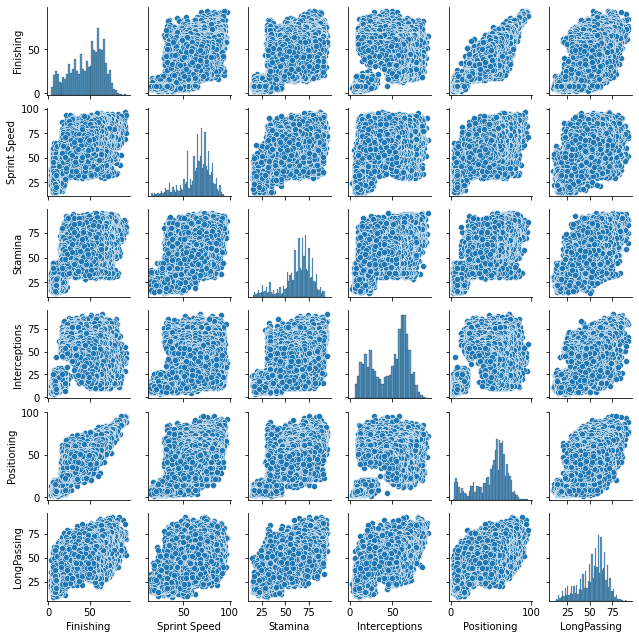

In [49]:
sns.pairplot(df[skills], height=1.5)

The clarity of this graph is:
- If Passing Total is good, Shooting Total score will be good too.
- If Dribbling Total is good, Shooting Total score will be good too.

# Feature Engineering

In [50]:
dfFeature = df[skills]
dfFeature

# rawDfFeature = df[skills]
# rawDfFeature

,Finishing,Sprint Speed,Stamina,Interceptions,Positioning,LongPassing
0,90,76,70,40,93,90
1,92,80,82,39,92,76
2,94,75,76,49,94,70
3,85,73,88,66,88,93
4,93,97,87,38,92,71
...,...,...,...,...,...,...
18534,49,68,32,22,50,33
18535,33,57,34,46,35,45
18536,36,59,36,24,42,52
18537,20,51,49,54,23,22


In [51]:
# for Box-Cox Transformation
boxcox = PowerTransformer(method='box-cox')
# normalize the exponential data with boxcox
FeatureData = boxcox.fit_transform(dfFeature)

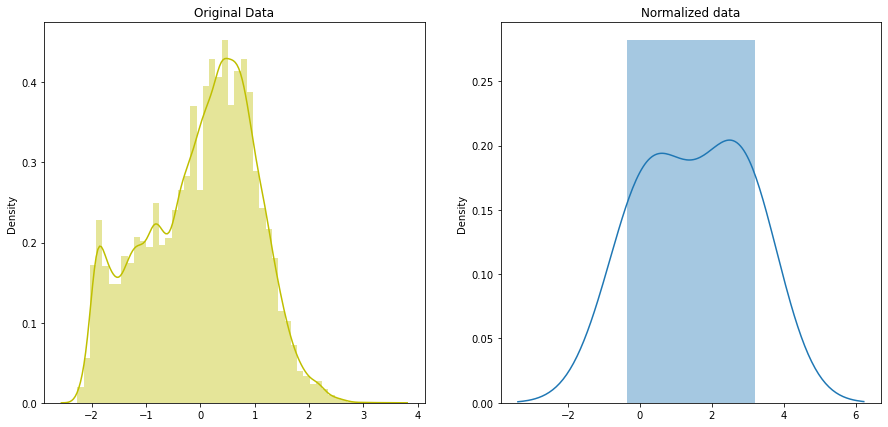

In [52]:
#plot both together to compare
fig, ax=plt.subplots(1,2)
fig.set_size_inches(15,7)
sns.distplot(FeatureData, ax=ax[0], color='y')
ax[0].set_title("Original Data")
sns.distplot(FeatureData[0], ax=ax[1])
ax[1].set_title("Normalized data")
plt.show()

# Kmeans Model

In [53]:
# r = 6
# from_k = 1
# to_k = 10

r = 4
from_k = 2
to_k = 9

# Modeling

## Evaluation

In [54]:
def elblowPlot(X, from_k, to_k):
    distortions = []
    for k in range(from_k, to_k):
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(X)
        distortions.append([k, kmeanModel.inertia_])

In [55]:
elblowPlot(FeatureData, from_k, to_k)

In [56]:
wss = []
sil = []
k_Cluster_List = []

k = range(from_k, to_k)
for n in k:
    # initialize clustering model
    algorithm = (KMeans(n_clusters = n, random_state=r))
    algorithm.fit(FeatureData)
    labels = algorithm.labels_
    cluster_k = f'k_m1_{n}'
    df[cluster_k] = labels
    k_Cluster_List.append(cluster_k)
    
    wss.append(algorithm.inertia_)
    sil.append(silhouette_score(FeatureData, labels, metric = 'euclidean'))

Text(0, 0.5, 'Silhouette Score')

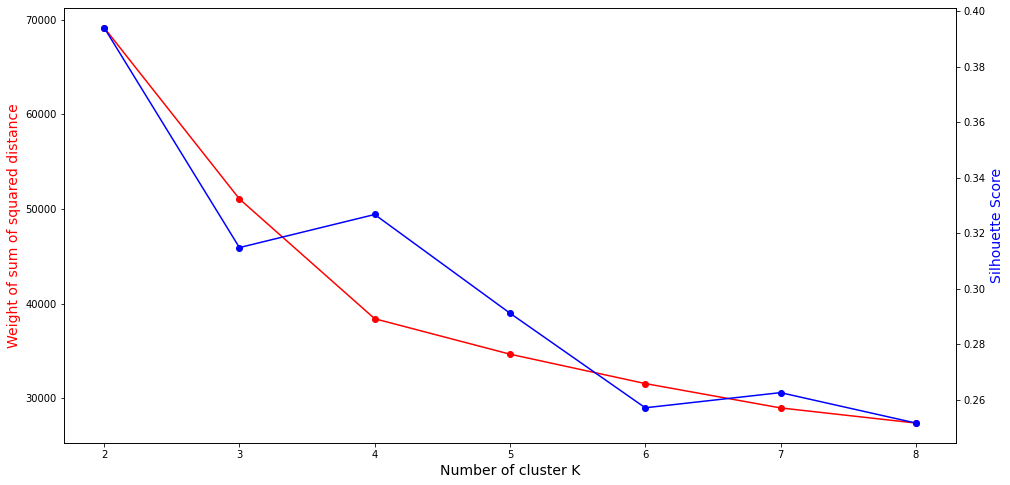

In [57]:
#plot graph first
fig,ax = plt.subplots()
fig.set_size_inches(16,8)
ax.plot(k, wss, color="red", marker="o")
ax.set_xlabel("Number of cluster K",fontsize=14)
ax.set_ylabel("Weight of sum of squared distance",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot(k, sil,color="blue",marker="o")
ax2.set_ylabel("Silhouette Score",color="blue",fontsize=14)

# plt.axvline(4, lw=4, linestyle='--')
# plt.show()

## Interpretation

In [58]:
InterPretShowData = ["Full Name"]
InterPretShowData.extend(skills)
InterPretShowData.extend(k_Cluster_List)

In [59]:
df[InterPretShowData]

,Full Name,Finishing,Sprint Speed,Stamina,Interceptions,Positioning,LongPassing,k_m1_2,k_m1_3,k_m1_4,k_m1_5,k_m1_6,k_m1_7,k_m1_8
0,Lionel Messi,90,76,70,40,93,90,0,2,0,2,1,2,6
1,Karim Benzema,92,80,82,39,92,76,0,2,0,2,5,1,2
2,Robert Lewandowski,94,75,76,49,94,70,0,2,0,2,5,1,2
3,Kevin De Bruyne,85,73,88,66,88,93,0,0,0,0,1,2,6
4,Kylian Mbappé,93,97,87,38,92,71,0,2,0,2,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18534,Darren Collins,49,68,32,22,50,33,1,2,1,1,3,6,5
18535,Dejiang Yang,33,57,34,46,35,45,1,1,3,4,2,0,7
18536,Liam Mullan,36,59,36,24,42,52,1,1,3,1,3,6,5
18537,Daithí McCallion,20,51,49,54,23,22,1,1,2,3,2,0,7


## K = 3

In [60]:
model = KMeans(n_clusters=3,random_state=r)
model.fit(FeatureData)
model.cluster_centers_.round(4)

array([[-0.1225,  0.0295,  0.4379,  0.7778,  0.017 ,  0.4431],
       [-1.6246, -1.4837, -1.589 , -1.1494, -1.7197, -1.5155],
       [ 0.9149,  0.595 , -0.0538, -0.8232,  0.7189, -0.0947]])

In [61]:
df.groupby('k_m1_3')[skills].mean()

,Finishing,Sprint Speed,Stamina,Interceptions,Positioning,LongPassing
k_m1_3,,,,,,
0,44.297187,66.205248,70.284664,62.887486,51.980916,60.151774
1,13.279097,39.817049,33.664072,22.686259,13.521214,29.239004
2,63.926045,73.389237,63.477746,30.059401,64.119310,52.936707


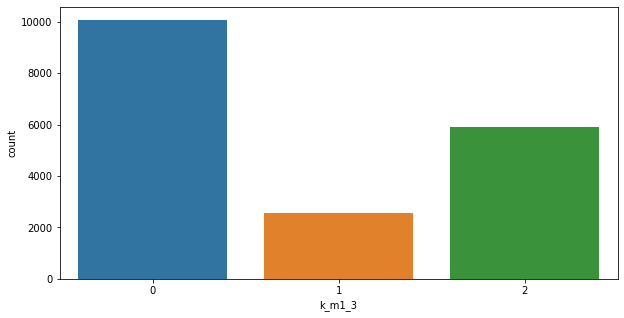

In [62]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='k_m1_3', data=df);

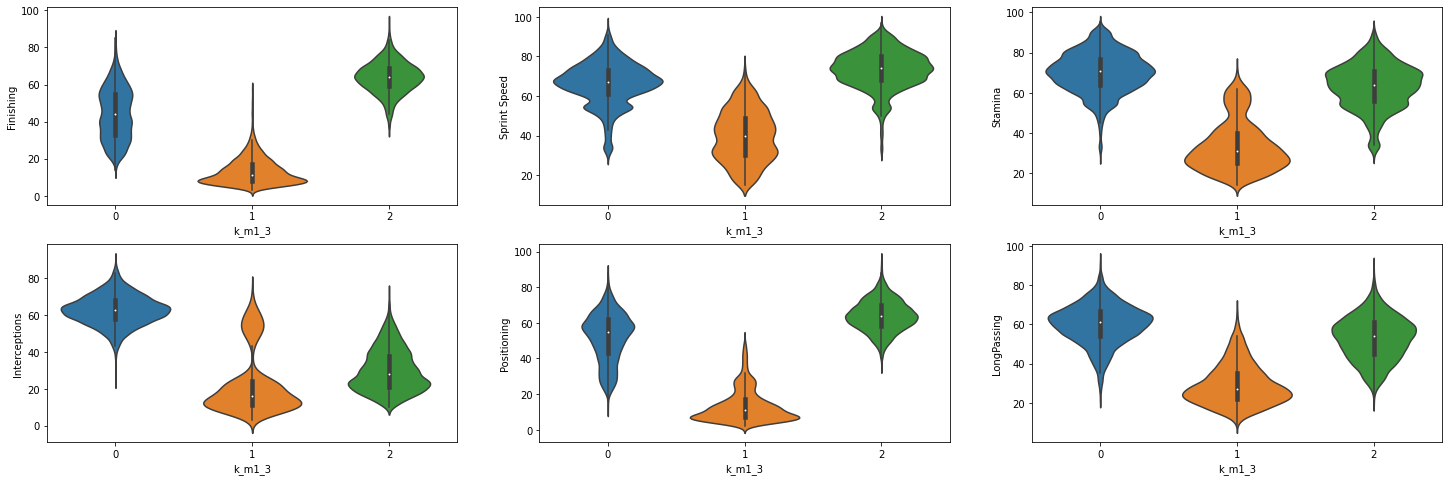

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,8))
ax = ax.ravel()
for pos, col in enumerate(skills):
  sns.violinplot(x='k_m1_3', y=col, data=df, ax=ax[pos])

## K = 4

In [64]:
model = KMeans(n_clusters=4,random_state=r)
model.fit(FeatureData)
model.cluster_centers_.round(4)

array([[ 0.4951,  0.3435,  0.8562,  0.7732,  0.6572,  0.9181],
       [ 0.8749,  0.5539, -0.1526, -0.9213,  0.6563, -0.2277],
       [-1.7367, -1.6478, -1.7886, -1.4878, -1.8429, -1.6119],
       [-0.6843, -0.2561, -0.0557,  0.6486, -0.6021, -0.1148]])

In [65]:
df.groupby('k_m1_4')[skills].mean()

,Finishing,Sprint Speed,Stamina,Interceptions,Positioning,LongPassing
k_m1_4,,,,,,
0,56.101110,70.290646,75.677999,62.790558,63.158887,66.216664
1,63.201178,72.905965,62.154255,28.016337,63.163374,51.210296
2,10.790731,36.377449,29.120879,15.579551,10.016722,27.322026
3,33.381471,62.322071,63.751680,60.320618,40.796912,52.758765


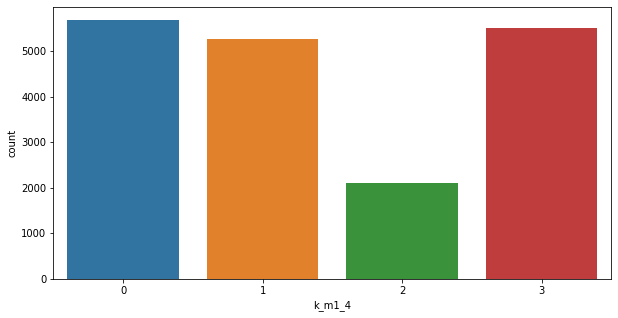

In [66]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='k_m1_4', data=df);

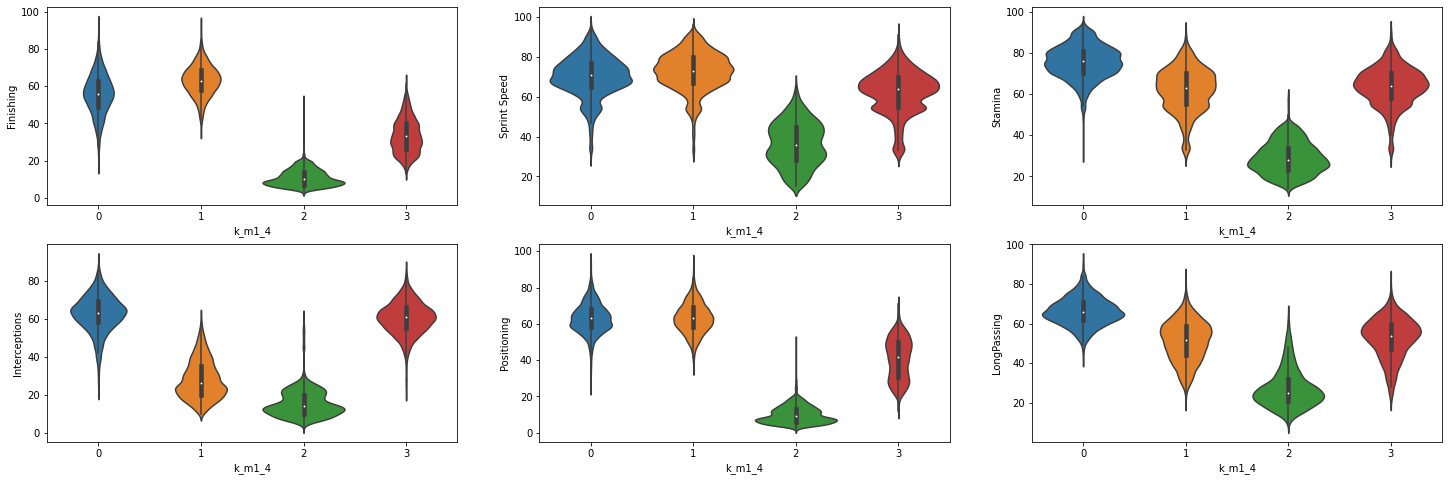

In [67]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,8))
ax = ax.ravel()
for pos, col in enumerate(skills):
  sns.violinplot(x='k_m1_4', y=col, data=df, ax=ax[pos])

## K = 5

In [68]:
model = KMeans(n_clusters=5,random_state=r)
model.fit(FeatureData)
model.cluster_centers_.round(4)

array([[ 0.3726,  0.2007,  0.8176,  0.8644,  0.5539,  0.9109],
       [ 0.6971,  0.2013, -0.5272, -0.9874,  0.4274, -0.4599],
       [ 1.107 ,  1.082 ,  0.4925, -0.5959,  1.0052,  0.292 ],
       [-1.7393, -1.6498, -1.7908, -1.4908, -1.8453, -1.6121],
       [-0.7384, -0.2547, -0.0637,  0.657 , -0.6585, -0.1722]])

In [69]:
df.groupby('k_m1_5')[skills].mean()

,Finishing,Sprint Speed,Stamina,Interceptions,Positioning,LongPassing
k_m1_5,,,,,,
0,53.845813,68.559993,75.211314,64.603993,61.535774,66.141061
1,59.971280,68.717690,56.644974,26.571036,59.554232,47.863428
2,67.423315,79.160656,71.359563,34.916940,68.627687,58.445173
3,10.735026,36.332056,29.068040,15.513656,9.952563,27.314806
4,32.339900,62.320995,63.670249,60.493333,39.736318,51.990647


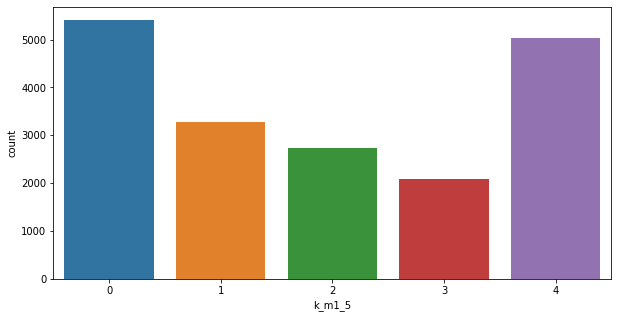

In [70]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='k_m1_5', data=df);

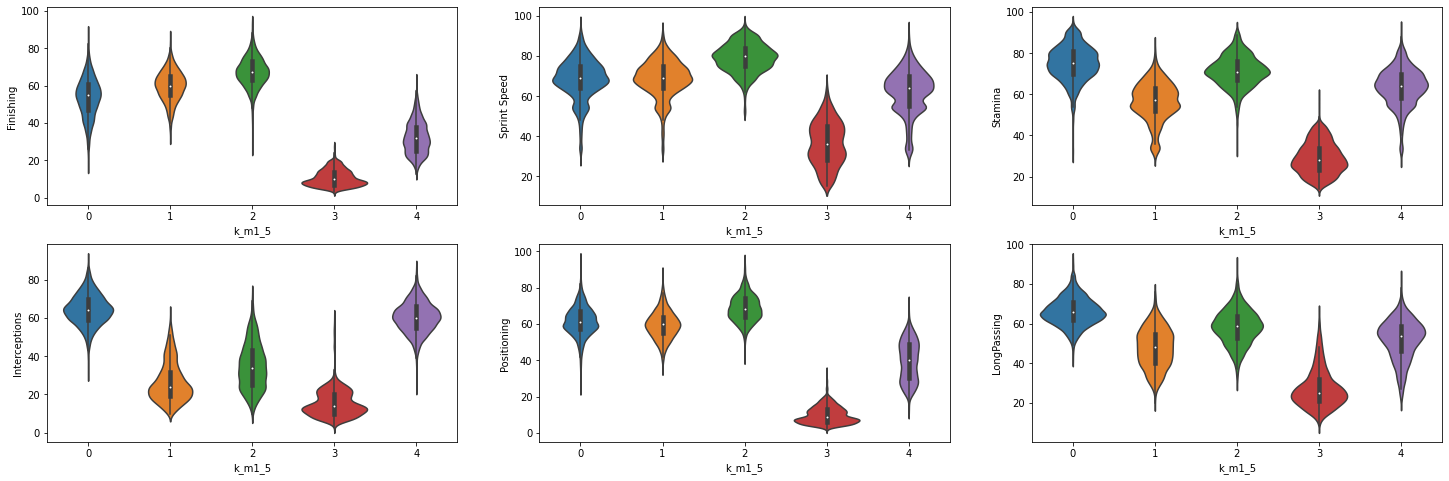

In [71]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,8))
ax = ax.ravel()
for pos, col in enumerate(skills):
  sns.violinplot(x='k_m1_5', y=col, data=df, ax=ax[pos])

# Visualizing 3D 

In [72]:
def color_change_3d(data,col,round):
  Colors = ['blue','orange','green','red','purple',"pink"]
  dic = {}
  for i in range(0, round):
    dic[i] = Colors[i]

  return data[col].map(dic)

In [73]:
features = df[skills]
umap_3d = umap.UMAP(n_components=3, init='random', random_state=r)
proj_3d = umap_3d.fit_transform(features)

In [74]:
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=("Model 1 k = 3", "Model 1  k = 4", "Model 1 k = 5"),
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}, {"type": "scatter3d"}]])

fig.add_trace(go.Scatter3d(x=proj_3d[:,0], 
                           y=proj_3d[:,1], 
                           z=proj_3d[:,2], 
                           mode="markers",
                           marker=dict(color=color_change_3d(df,'k_m1_3',3),size=5,showscale=False)),
                           row=1, col=1)

fig.add_trace(go.Scatter3d(x=proj_3d[:,0], 
                           y=proj_3d[:,1],
                           z=proj_3d[:,2], 
                           mode="markers",
                           marker=dict(color=color_change_3d(df,'k_m1_4',4),size=5,showscale=False)),
                           row=1, col=2)

fig.add_trace(go.Scatter3d(x=proj_3d[:,0], 
                           y=proj_3d[:,1],
                           z=proj_3d[:,2], 
                           mode="markers",
                           marker=dict(color=color_change_3d(df,'k_m1_5',5),size=5,showscale=False)),
                           row=1, col=3)

fig.update_layout(height=700,title_text="Visualizing 3D Modeling", showlegend=False)
fig.show()

# Summary and interpretation in each cluster
> I would use a model that is grouped into 4 groups because during the model evaluation, the number K = 4 can show a better difference than the other K numbers.

- Cluster 1 (Blue Color) 
  - I will call them 'Controllers' and will attempt to control and dictate the tempo of the game. because they have the good offensive ability to have a good defense score too and they can provide the link between the attack and the defense. (Position midfielder: CAM, CM, CF)
- Cluster 2 (Orange Color)
  - I will call them "Scorer" because the attack ability is quite better than the Controller, but the ability to defend is worse. Therefore, they are better suited to be scorers. (Position forward: LW, ST, RW)
- Cluster 3 (Green Color)
  - All skill points are low. They are unable to play offensively and defensively. Which they are likely to be positioned as "Goalkeeper" (The reason for the low score Because normal player and goalkeeper scores are not counted as the same and I didn't put his goalkeeper's score in the model.)
- Cluster 4 (Red Color)
  - Overall, their defensive scores were much better than their offensive and their finishing scores were very low. They probably would have been better suited to the "Defender" position.

# Pipeline

In [75]:
class Pipeline:
    def __init__(self, data, skills):

        self.transformer = PowerTransformer(method='box-cox')
        self.skills = skills
        self.data = data[self.skills]

    def train(self,data):
        result = self.transformer.fit_transform(data[self.skills])
        return result

    def predict(self,data):
        result = self.transformer.transform(data[self.skills])
        return result


In [76]:
getData = refData
skills = ['Finishing', 'Sprint Speed', 'Stamina', 'Interceptions', 'Positioning', 'LongPassing']
pipeline = Pipeline(getData,skills)

In [77]:
tfData = pipeline.train(pipeline.data)
tfData

array([[ 2.38351594,  0.75796222,  0.35172937, -0.35958692,  2.73887643,
         3.18977518],
       [ 2.49954772,  1.12729756,  1.37567177, -0.40788835,  2.6621402 ,
         1.77535432],
       [ 2.61596915,  0.66917747,  0.8411827 ,  0.08032034,  2.81602837,
         1.2239197 ],
       ...,
       [-0.564202  , -0.56204314, -1.59372765, -1.1154315 , -0.58123497,
        -0.22393146],
       [-1.33678303, -1.04742566, -1.01311619,  0.3283735 , -1.44012085,
        -1.88403726],
       [-0.95911109, -0.93401685, -0.61762473, -0.35958692, -0.87948841,
        -1.58837441]])

In [78]:
model = KMeans(n_clusters=4, random_state=r)
model.fit(tfData)

KMeans(n_clusters=4, random_state=4)

# Deployment

In [79]:
Finishing = gr.inputs.Slider(minimum=0, maximum=100,step=1, default=0, label='Finishing')
SprintSpeed = gr.inputs.Slider(minimum=0, maximum=100,step=1, default=0, label='Sprint Speed')
Stamina = gr.inputs.Slider(minimum=0, maximum=100,step=1, default=0, label='Stamina')
Interceptions = gr.inputs.Slider(minimum=0, maximum=100,step=1, default=0, label='Interceptions')
Positioning = gr.inputs.Slider(minimum=0, maximum=100,step=1, default=0, label='Positioning')
LongPassing = gr.inputs.Slider(minimum=0, maximum=100,step=1, default=0, label='LongPassing')

In [80]:
def deployment(Finishing,SprintSpeed,Stamina,Interceptions,Positioning,LongPassing):
  inputData = pd.DataFrame({
      "LongPassing":LongPassing,
      "Finishing" : Finishing,
      "Interceptions" : Interceptions,
      "Positioning" : Positioning,
      "Sprint Speed" : SprintSpeed,
      "Stamina" : Stamina
      }, index=[0])
  result = pipeline.predict(inputData)
  Cluster = ["Controllers","Scorer","Goalkeeper","Defender"]

  return Cluster[model.predict(result)[0]]

In [81]:
deployment(90, 74, 70, 40, 93, 90)

'Controllers'

In [82]:
iface = gr.Interface(deployment,inputs=[LongPassing,Finishing,Interceptions,Positioning,SprintSpeed,Stamina],outputs="text")
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://22837.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f3ff2964990>,
 'http://127.0.0.1:7861/',
 'https://22837.gradio.app')